**Downloading the data**



In [39]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  11.1M      0  0:00:07  0:00:07 --:--:-- 9098k


Preparing the data

In [40]:
import os, pathlib, shutil, random
from tensorflow import keras
batchSize = 32
base_dir= pathlib.Path("/content/aclImdb")
validation_dir = base_dir/ "val"
training_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(validation_dir / category, exist_ok=True )

    files = os.listdir(training_dir / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    validation_files = files[-num_val_samples:]
    for fname in validation_files:
        shutil.move(training_dir / category / fname,
                    validation_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batchSize
).take(100)  # Restrict training samples to 100

val_ds = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batchSize
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batchSize
)
te_only_train_ds = train_ds.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Preparation of datasets for numeric sequences

**A sequence model constructed on one-hot encoded digital sequences**

In [41]:
from tensorflow.keras import layers

MAX_SEQUENCE_LENGTH = 150   # Cutoff reviews after 150 words
MAX_VOCAB_SIZE = 10000      # Consider only the top 10,000 words

# Define TextVectorization layer
t_vectorization = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

# Extract texts only from train_ds for vectorization adaptation
train_texts_only = train_ds.map(lambda x, y: x)
t_vectorization.adapt(train_texts_only)

# Vectorize the train, validation, and test datasets
int_train_dataset = train_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)
int_val_dataset = val_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)
int_test_ds = test_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)


In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the maximum vocabulary size
MAX_VOCAB_SIZE = 10000  # Example: adjust this based on your dataset

# Define the model
input_layer = layers.Input(shape=(None,), dtype="int64")
embedding_output = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_layer)
y = layers.Bidirectional(layers.LSTM(32))(embedding_output)
y = layers.Dropout(0.5)(y)
output_layer = layers.Dense(1, activation="sigmoid")(y)

# Build and compile the model
model = models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Display model summary
model.summary()



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, None, 256)      │      2,560,000 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_9 (NotEqual)    │ (None, None)           │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_9           │ (None, 64)             │         73,984 │ embedding_11[0][0],    │
│ (Bidirectional)           │                        │                │ not_equal_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64)             │              0 │ bidirectional_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │             65 │ dropout_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Developing a fundamental sequencing concept initially

In [43]:
checkpoint_callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
# Ensure this is run before plotting
history = model.fit(int_train_dataset, validation_data=int_val_dataset, epochs=15, callbacks=checkpoint_callbacks)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.5477 - loss: 0.6898 - val_accuracy: 0.6425 - val_loss: 0.6333
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.7107 - loss: 0.5694 - val_accuracy: 0.6715 - val_loss: 0.6083
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7950 - loss: 0.4381 - val_accuracy: 0.7822 - val_loss: 0.4577
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8627 - loss: 0.3289 - val_accuracy: 0.7963 - val_loss: 0.4388
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9033 - loss: 0.2363 - val_accuracy: 0.7836 - val_loss: 0.4982
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9340 - loss: 0.1720 - val_accuracy: 0.7438 - val_loss: 0.6404
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9616 - loss: 0.1211 - val_accuracy: 0.7700 - val_loss: 0.5511
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9789 - loss: 0.0765 - val_ac

In [44]:
loaded_model = keras.models.load_model('one_hot_bidir_lstm.keras')
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7810 - loss: 0.7955
Test acc: 0.782


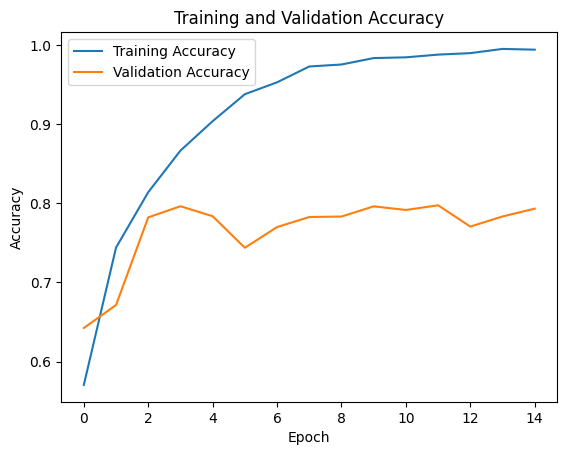

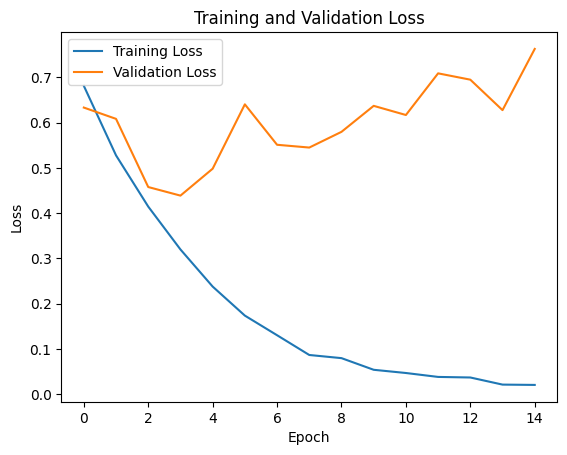

In [45]:

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# In this work, the Embedded level is employed in order to obtain the embedded words.

Implementation of an Anchoring level


In [46]:
embedding_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)

Anchor layer system which was developed form start

In [47]:
input_tensor = keras.Input(shape=(None,), dtype="int64")
embedding_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)(input_tensor)
x = layers.Bidirectional(layers.LSTM(32))(embedding_layer)
x = layers.Dropout(0.5)(x)
output_layer1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input_tensor, output_layer1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_13 (Embedding)             │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
checkpoint_callbacks1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",  # Change to .keras
                                    save_best_only=True)
]

history1 = model.fit(int_train_dataset, validation_data=int_val_dataset, epochs=15, callbacks=checkpoint_callbacks1)

# Load the best model saved by the callback
model = keras.models.load_model("embeddings_bidir_gru.keras")

# Evaluate the model on the test dataset
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5227 - loss: 0.6929 - val_accuracy: 0.5812 - val_loss: 0.6771
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.6538 - loss: 0.6393 - val_accuracy: 0.6342 - val_loss: 0.6631
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7645 - loss: 0.5093 - val_accuracy: 0.7735 - val_loss: 0.4967
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8368 - loss: 0.4026 - val_accuracy: 0.7466 - val_loss: 0.5156
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8664 - loss: 0.3392 - val_accuracy: 0.7541 - val_loss: 0.5102
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9084 - loss: 0.2504 - val_accuracy: 0.7845 - val_loss: 0.4991
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9430 - loss: 0.1812 - val_accuracy: 0.7824 - val_loss: 0.5114
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9546 - loss: 0.1368 - val_ac

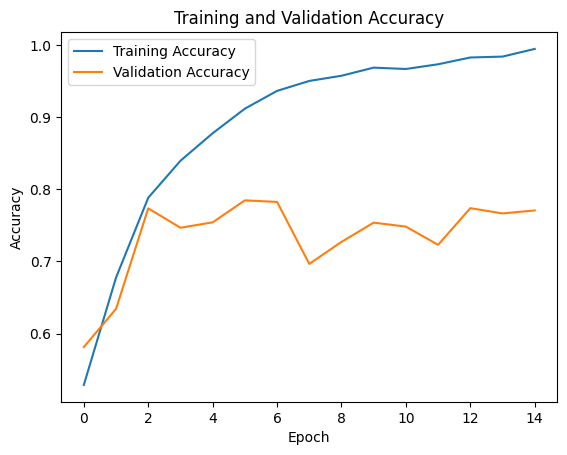

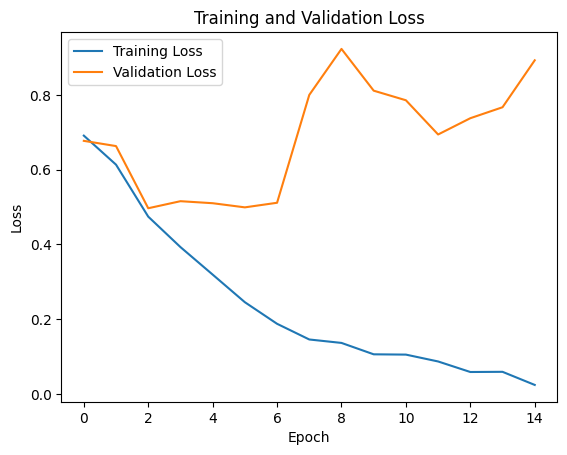

In [49]:
# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Recognizing blurring and filling

Applying filtering to an Anchoring level


In [52]:
input_tensor_2 = keras.Input(shape=(None,), dtype="int64")
embedding_layer_2 = layers.Embedding(
    input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_tensor_2)
x = layers.Bidirectional(layers.LSTM(32))(embedding_layer_2)
x = layers.Dropout(0.5)(x)
output_layer2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input_tensor_2, output_layer2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_15 (Embedding)  │ (None, None, 256)      │      2,560,000 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_12 (NotEqual)   │ (None, None)           │              0 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_12          │ (None, 64)             │         73,984 │ embedding_15[0][0],    │
│ (Bidirectional)           │                        │                │ not_equal_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 64)             │              0 │ bidirectional_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 1)              │             65 │ dropout_12[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
checkpoint_callbacks2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history2=model.fit(int_train_dataset, validation_data= int_val_dataset, epochs=15, callbacks=checkpoint_callbacks2)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.5224 - loss: 0.6906 - val_accuracy: 0.6370 - val_loss: 0.6405
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.7159 - loss: 0.5825 - val_accuracy: 0.7756 - val_loss: 0.4932
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8097 - loss: 0.4215 - val_accuracy: 0.7696 - val_loss: 0.4981
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8687 - loss: 0.3169 - val_accuracy: 0.7686 - val_loss: 0.5317
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9047 - loss: 0.2489 - val_accuracy: 0.8019 - val_loss: 0.4677
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9410 - loss: 0.1685 - val_accuracy: 0.7930 - val_loss: 0.4966
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9573 - loss: 0.1199 - val_accuracy: 0.7829 - val_loss: 0.6088
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9708 - loss: 0.0844 - val

In [54]:

model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8014 - loss: 0.4683
Test acc: 0.802


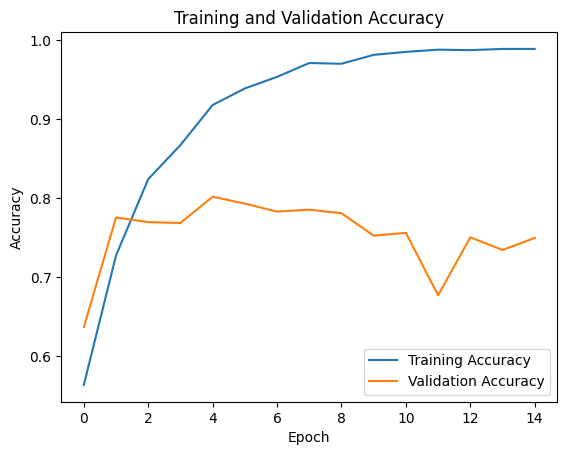

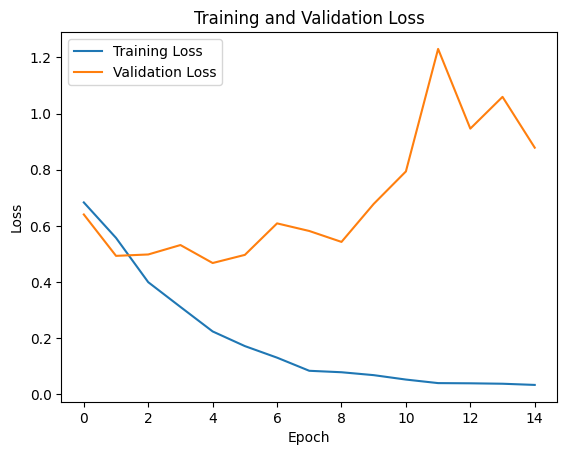

In [55]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Preconditioned word embeds are used

In [56]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-18 04:49:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-18 04:49:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-18 04:49:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Interpreting the word-embeddings package for One

In [57]:
import numpy as np
GLOVE_FILE_PATH = "glove.6B.100d.txt"

glove_embeddings = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

print(f"Found {len(glove_embeddings)} word vectors.")

Found 400000 word vectors.


Setting up the matrix for the GloVe website embedded words

In [58]:
em_dim = 100

vocab = t_vectorization.get_vocabulary()
word_to_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, em_dim))
for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        em_vector = glove_embeddings.get(word)
    if em_vector is not None:
        embedding_matrix[i] = em_vector

In [59]:
em_layer = layers.Embedding(
    MAX_VOCAB_SIZE,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

# Architecture with an embedded level which has been trained

In [60]:
input_tensor_4 = keras.Input(shape=(None,), dtype="int64")
embedding_layer_4 = em_layer(input_tensor_4)
x = layers.Bidirectional(layers.LSTM(32))(embedding_layer_4)
x = layers.Dropout(0.5)(x)
output_layer4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input_tensor_4, output_layer4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_16 (Embedding)  │ (None, None, 100)      │      1,000,000 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_14 (NotEqual)   │ (None, None)           │              0 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_13          │ (None, 64)             │         34,048 │ embedding_16[0][0],    │
│ (Bidirectional)           │                        │                │ not_equal_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 64)             │              0 │ bidirectional_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 1)              │             65 │ dropout_13[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [61]:
checkpoint_callbacks4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]

history4=model.fit(int_train_dataset, validation_data= int_val_dataset, epochs=15, callbacks=checkpoint_callbacks4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test Accuracy: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.5283 - loss: 0.7010 - val_accuracy: 0.6374 - val_loss: 0.6478
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.6528 - loss: 0.6345 - val_accuracy: 0.7042 - val_loss: 0.5794
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7072 - loss: 0.5692 - val_accuracy: 0.7229 - val_loss: 0.5579
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7317 - loss: 0.5453 - val_accuracy: 0.7010 - val_loss: 0.5857
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.7510 - loss: 0.5124 - val_accuracy: 0.7446 - val_loss: 0.5258
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.7655 - loss: 0.4908 - val_accuracy: 0.7674 - val_loss: 0.4906
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.7844 - loss: 0.4722 - val_accuracy: 0.7621 - val_loss: 0.4920
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.8012 - loss: 0.4475

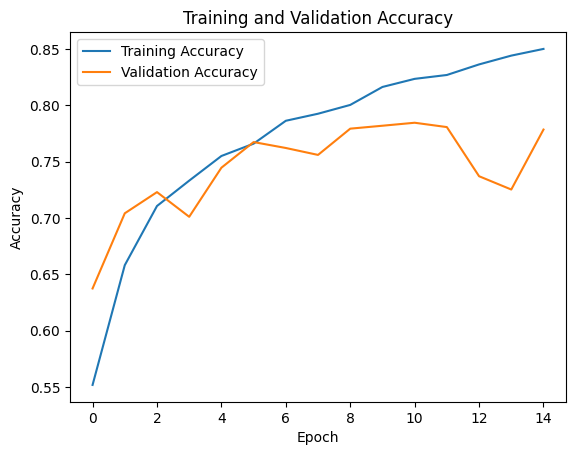

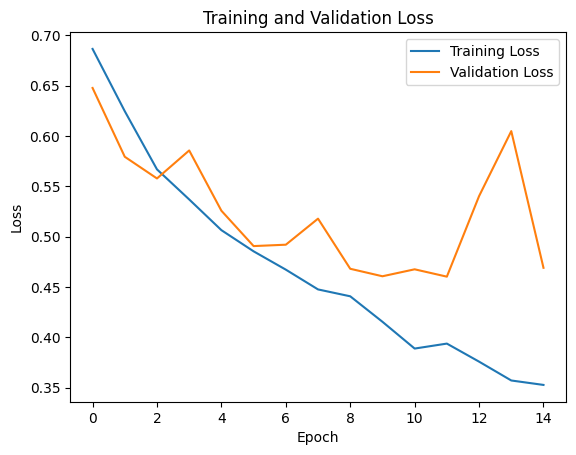

In [62]:
# Plot training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5115 - loss: 0.6938 - val_accuracy: 0.5798 - val_loss: 0.6884
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5926 - loss: 0.6749 - val_accuracy: 0.6452 - val_loss: 0.6243
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.7329 - loss: 0.5658 - val_accuracy: 0.6585 - val_loss: 0.6327
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8032 - loss: 0.4628 - val_accuracy: 0.7326 - val_loss: 0.5436
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.8582 - loss: 0.3550 - val_accuracy: 0.7214 - val_loss: 0.5937
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9006 - loss: 0.2796 - val_accuracy: 0.7860 - val_loss: 0.4967
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9197 - loss: 0.2200 - val_accuracy: 0.7784 - val_loss: 0.4818
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step

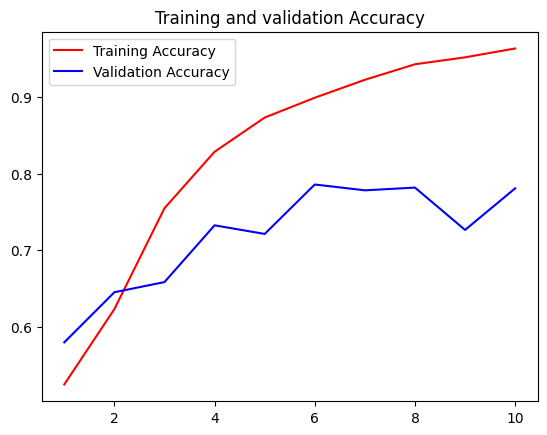

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.5132 - loss: 0.7069 - val_accuracy: 0.5958 - val_loss: 0.6661
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.6031 - loss: 0.6652 - val_accuracy: 0.6892 - val_loss: 0.5876
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.6616 - loss: 0.6251 - val_accuracy: 0.7039 - val_loss: 0.5825
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.7134 - loss: 0.5600 - val_accuracy: 0.7420 - val_loss: 0.5275
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7428 - loss: 0.5284 - val_accuracy: 0.7577 - val_loss: 0.5003
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.7571 - loss: 0.5103 - val_accuracy: 0.7576 - val_loss: 0.5020
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.7514 - loss: 0.4912 - val_accuracy: 0.7689 - val_loss: 0.4847
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.7856 - loss: 0.46

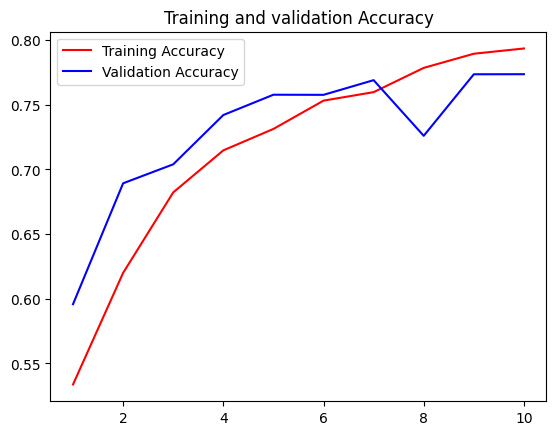

Training samples: 100
Embedding layer test accuracy: 0.770
Pretrained embeddings test accuracy: 0.773
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.5145 - loss: 0.6913 - val_accuracy: 0.6999 - val_loss: 0.6143
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7283 - loss: 0.5721 - val_accuracy: 0.7539 - val_loss: 0.5302
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.8200 - loss: 0.4313 - val_accuracy: 0.7458 - val_loss: 0.5614
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8709 - loss: 0.3368 - val_accuracy: 0.8139 - val_loss: 0.4458
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.8980 - loss: 0.2830 - val_accuracy: 0.7340 - val_loss: 0.9387
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9058 - loss: 0.2535 - val_accuracy: 0.8120 - val_loss: 0.5228
Epoch 7/10
157/157 ━━━━━━━━━━

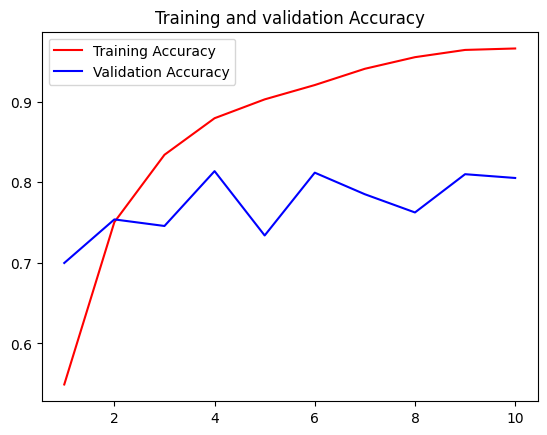

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.5309 - loss: 0.7003 - val_accuracy: 0.7002 - val_loss: 0.5896
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.6600 - loss: 0.6266 - val_accuracy: 0.6557 - val_loss: 0.6320
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.7075 - loss: 0.5773 - val_accuracy: 0.7316 - val_loss: 0.5284
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7344 - loss: 0.5357 - val_accuracy: 0.7505 - val_loss: 0.5138
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.7536 - loss: 0.5064 - val_accuracy: 0.7621 - val_loss: 0.5086
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.7767 - loss: 0.4806 - val_accuracy: 0.7688 - val_loss: 0.4850
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7873 - loss: 0.4583 - val_accuracy: 0.6908 - val_loss: 0.6629
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8070 - loss: 0.4362 - val

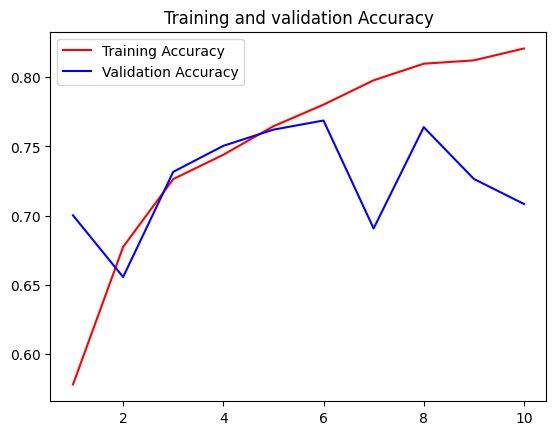

Training samples: 500
Embedding layer test accuracy: 0.807
Pretrained embeddings test accuracy: 0.762
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5020 - loss: 0.6921 - val_accuracy: 0.6970 - val_loss: 0.5965
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7101 - loss: 0.5848 - val_accuracy: 0.7081 - val_loss: 0.5674
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8143 - loss: 0.4336 - val_accuracy: 0.7315 - val_loss: 0.5344
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.8611 - loss: 0.3502 - val_accuracy: 0.8164 - val_loss: 0.4299
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8886 - loss: 0.2944 - val_accuracy: 0.6760 - val_loss: 0.8007
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9143 - loss: 0.2476 - val_accuracy: 0.8068 - val_loss: 0.4898
Epoch 7/10
157/157 ━━━━━━━━━━

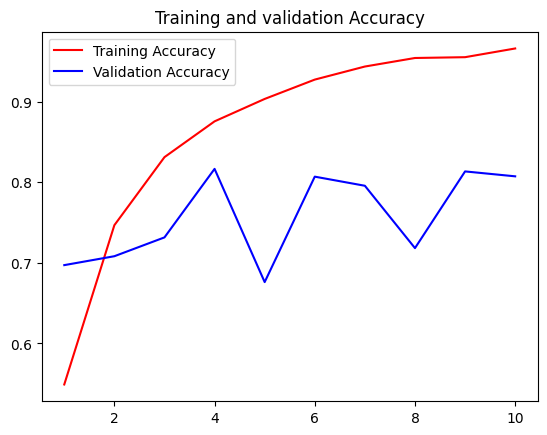

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.5201 - loss: 0.6972 - val_accuracy: 0.6421 - val_loss: 0.6334
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.6693 - loss: 0.6097 - val_accuracy: 0.7324 - val_loss: 0.5337
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7206 - loss: 0.5568 - val_accuracy: 0.6884 - val_loss: 0.5816
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.7439 - loss: 0.5320 - val_accuracy: 0.7657 - val_loss: 0.4975
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.7627 - loss: 0.5044 - val_accuracy: 0.7447 - val_loss: 0.5347
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7758 - loss: 0.4855 - val_accuracy: 0.7771 - val_loss: 0.4657
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7901 - loss: 0.4653 - val_accuracy: 0.7714 - val_loss: 0.5120
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7945 - loss: 0.4440 - v

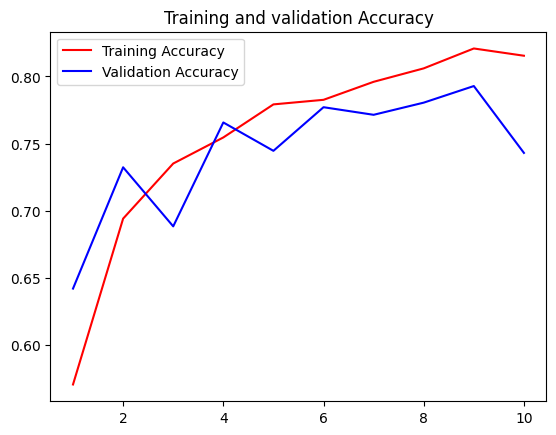

Training samples: 1000
Embedding layer test accuracy: 0.812
Pretrained embeddings test accuracy: 0.783
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.5147 - loss: 0.6921 - val_accuracy: 0.6916 - val_loss: 0.6244
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7039 - loss: 0.5899 - val_accuracy: 0.7225 - val_loss: 0.5615
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8100 - loss: 0.4382 - val_accuracy: 0.6702 - val_loss: 0.7389
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8575 - loss: 0.3567 - val_accuracy: 0.7093 - val_loss: 0.7390
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.8910 - loss: 0.2977 - val_accuracy: 0.8131 - val_loss: 0.4680
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9093 - loss: 0.2534 - val_accuracy: 0.8070 - val_loss: 0.5413
Epoch 7/10
157/157 ━━━━━━━━

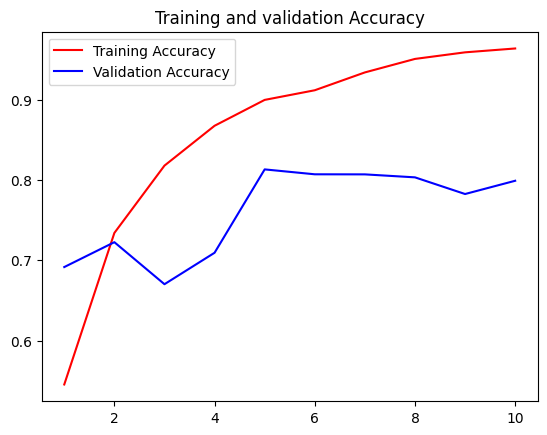

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.5312 - loss: 0.6953 - val_accuracy: 0.5981 - val_loss: 0.6660
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.6633 - loss: 0.6131 - val_accuracy: 0.5584 - val_loss: 0.7096
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7146 - loss: 0.5666 - val_accuracy: 0.5670 - val_loss: 0.7314
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.7360 - loss: 0.5302 - val_accuracy: 0.7093 - val_loss: 0.6499
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.7478 - loss: 0.5092 - val_accuracy: 0.6946 - val_loss: 0.6244
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7716 - loss: 0.4850 - val_accuracy: 0.7718 - val_loss: 0.4860
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7805 - loss: 0.4615 - val_accuracy: 0.7631 - val_loss: 0.4925
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7924 - loss: 0.4454 - va

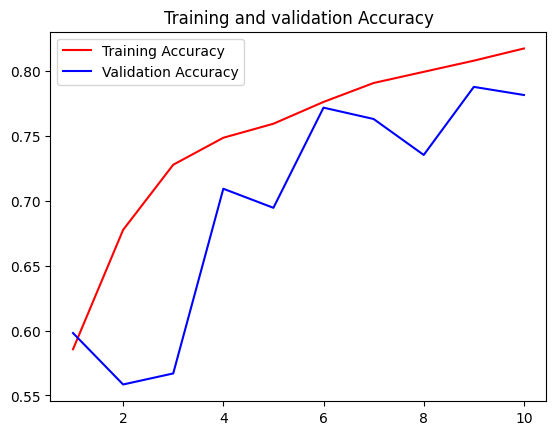

Training samples: 5000
Embedding layer test accuracy: 0.808
Pretrained embeddings test accuracy: 0.784
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.5057 - loss: 0.6916 - val_accuracy: 0.6819 - val_loss: 0.6095
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.7115 - loss: 0.5816 - val_accuracy: 0.7454 - val_loss: 0.5294
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8208 - loss: 0.4408 - val_accuracy: 0.7341 - val_loss: 0.5605
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8674 - loss: 0.3403 - val_accuracy: 0.7904 - val_loss: 0.4512
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9028 - loss: 0.2801 - val_accuracy: 0.8091 - val_loss: 0.4503
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9223 - loss: 0.2424 - val_accuracy: 0.8048 - val_loss: 0.5463
Epoch 7/10
157/157 ━━━━━━━━

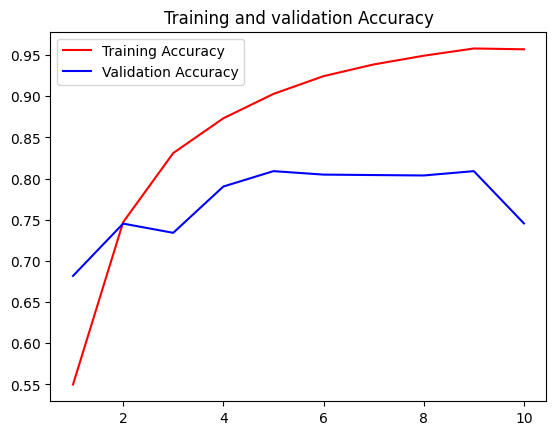

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5412 - loss: 0.6978 - val_accuracy: 0.5121 - val_loss: 0.7571
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.6453 - loss: 0.6318 - val_accuracy: 0.7337 - val_loss: 0.5439
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7185 - loss: 0.5651 - val_accuracy: 0.7583 - val_loss: 0.5034
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.7320 - loss: 0.5280 - val_accuracy: 0.7660 - val_loss: 0.4935
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7617 - loss: 0.5000 - val_accuracy: 0.7592 - val_loss: 0.5009
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.7784 - loss: 0.4675 - val_accuracy: 0.7740 - val_loss: 0.4722
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7862 - loss: 0.4611 - val_accuracy: 0.7854 - val_loss: 0.4554
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8030 - loss: 0.4309 - v

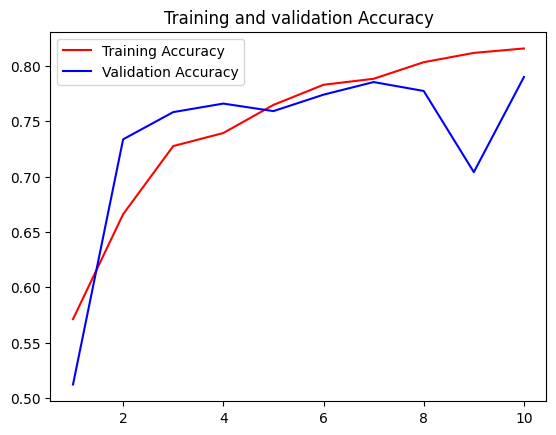

Training samples: 10000
Embedding layer test accuracy: 0.796
Pretrained embeddings test accuracy: 0.783
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.5199 - loss: 0.6933 - val_accuracy: 0.6137 - val_loss: 0.6701
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.6798 - loss: 0.6109 - val_accuracy: 0.6815 - val_loss: 0.6964
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.7944 - loss: 0.4744 - val_accuracy: 0.7824 - val_loss: 0.4707
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.8573 - loss: 0.3714 - val_accuracy: 0.7837 - val_loss: 0.4708
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.8876 - loss: 0.2906 - val_accuracy: 0.8112 - val_loss: 0.5190
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9121 - loss: 0.2423 - val_accuracy: 0.8063 - val_loss: 0.4614
Epoch 7/10
157/157 ━━━━━━

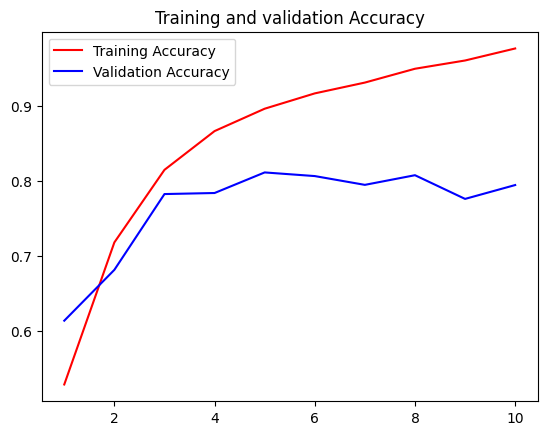

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.5576 - loss: 0.6896 - val_accuracy: 0.6935 - val_loss: 0.5943
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.6819 - loss: 0.5979 - val_accuracy: 0.7194 - val_loss: 0.5561
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.7267 - loss: 0.5544 - val_accuracy: 0.7398 - val_loss: 0.5162
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.7437 - loss: 0.5221 - val_accuracy: 0.7079 - val_loss: 0.6398
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.7604 - loss: 0.4966 - val_accuracy: 0.6829 - val_loss: 0.7176
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.7823 - loss: 0.4729 - val_accuracy: 0.7789 - val_loss: 0.4681
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.7949 - loss: 0.4495 - val_accuracy: 0.7724 - val_loss: 0.4709
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7955 - loss: 0.4394 - va

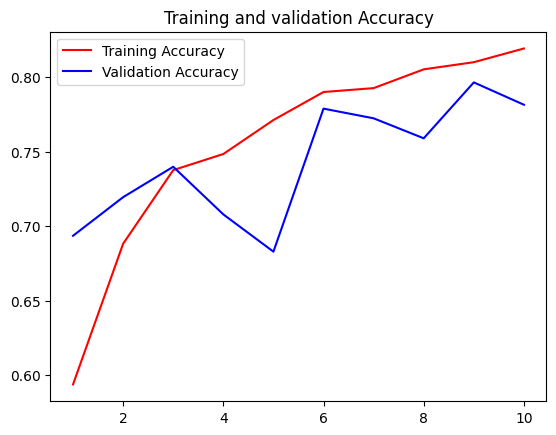

Training samples: 20000
Embedding layer test accuracy: 0.795
Pretrained embeddings test accuracy: 0.793
--------------------------------------------------


In [63]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batchSize
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = val_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = test_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")
    embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        MAX_VOCAB_SIZE,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.keras")
    pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)


